In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

In [ ]:
!pip install transformers

In [ ]:
# We'll need these libraries to gather and shape the data.
import requests 
import pandas as pd
from itertools import compress
import re

Procesamiento de Datos

In [ ]:
archivo = '/content/gdrive/MyDrive/dataRubenDarioEstrofasSN.txt'
characters = "—¡!¿?,;:'-<>."

datos3 = []
poema=""
with open(archivo) as fname:
  for linea in fname:
    linea = ''.join( x for x in linea if x not in characters)
    poema += linea[:-1]+".\n"
    if(linea.endswith("\n") and linea=='\n'):
      if(len(poema.split())>10 and len(poema.split())<40):
        poema=poema[:-2]
        datos3.append(poema)
      poema=""
print (datos3)
print (datos3[0])

print (len(datos3))

['Salve  dulce Primavera.\nque en la aurora de mi vida.\nme diste la bienvenida.\ncariñosa y placentera.\n', 'Tú ríes en la ribera.\nmientras yo en mi embarcación.\ncamino del remo al són.\npor el piélago azulado  .\nay qué llevaré guardado.\ndentro de mi corazón.\n', 'esplendente claridad.\nde brillo santo y fecundo.\nque derrama sobre el mundo.\nfe esperanza y caridad.\n', 'creación gigante que asombra.\nDios que el labio no le nombra.\nsin una oración bendita.\nla luz la gloria infinita.\ny   de repente la sombra.\n', 'Tengo de preguntaros oh divinas.\nMusas si el plectro humilde que meneo.\nmejor produzca los marciales himnos.\ny dé armonía al cántico guerrero.\n', 'o de natura los preciados dones.\nensalce al són de cadenciosos versos.\no en églogas armónicas repita.\nde Títiro el cantar y Melibeo.\n', 'Decidme sacras Musas si el coturno.\ntrágico calce de grandioso fuego.\nhenchido el corazón o si la trompa.\nque puede producir los cantos épicos.\n', 'empuñe osado o si la ebúrnea

Convertir a formato cvs

In [ ]:
#cvs
import requests 
import pandas as pd
from itertools import compress

df = pd.DataFrame(
    datos3,
    columns=['data']
    )

poemas = df.data.copy()

# GPT2 Tokenizer

In [ ]:
from transformers import AutoTokenizer, AutoModelWithLMHead
  
tokenizer = AutoTokenizer.from_pretrained("datificate/gpt2-small-spanish",
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>')
print(tokenizer.encode("no creo"))
print(tokenizer.encode("puedo hacerlo yo se que puedo"))

[831, 22315]
[21509, 302, 7423, 6582, 306, 301, 22178]


#Max token
Saber cual es el poema mas alto

In [ ]:
max_tokens_poema = max([len(tokenizer.encode(poema)) for poema in poemas])

print("el poema mas largo tiene "+max_tokens_poema+ "tokens")


The longest flavour text is 80 tokens long.


In [ ]:

!nvidia-smi

Fri May 14 04:23:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    76W / 149W |   4156MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
torch.manual_seed(42)
from torch.utils.data import Dataset # this is the pytorch class import

class EstrofaDataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=max_tokens_poema):

    self.tokenizer = tokenizer # the gpt2 tokenizer we instantiated
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:
      """
      This loop will iterate through each entry in the flavour text corpus.
      For each bit of text it will prepend it with the start of text token,
      then append the end of text token and pad to the maximum length with the 
      pad token. 
      """

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', 
                                 truncation=True, 
                                 max_length=max_length, 
                                 padding="max_length")
      
      """
      Each iteration then appends either the encoded tensor to a list,
      or the attention mask for that encoding to a list. The attention mask is
      a binary list of 1's or 0's which determine whether the langauge model
      should take that token into consideration or not. 
      """
      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

Training 80 validacion 20

In [ ]:
from torch.utils.data import random_split

dataset = EstrofaDataset(poemas, tokenizer, max_length=max_tokens_poema)

# Split into training and validation sets
train_size = int(0.8* len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f'TEntrenamineto : {train_size} ,validadcion {val_size} ')

'There are 1446 samples for training, and 161 samples for validation testing'

ejemplo de token

In [ ]:
dataset[0]

(tensor([   28,    92, 28495,   300,    70, 16431,    84,    92,    30,  8418,
           646,   221,  9746, 27371,    14,   199,   292,   278,   276, 19821,
           765,   258,  3514,  1160,    14,   199,   703,   505,   286,   276,
         22807,    14,   199,   694, 31063,    65,   287, 39986,  1362,    14,
           199,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]))

Hyper parametros


In [ ]:
batchSize = 32 


DAta

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), # Sampling for training is random
            batch_size = batchSize
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), # Sampling for validation is sequential as the order doesn't matter.
            batch_size = batchSize 
        )

# Finetune GPT2 Language Model

In [ ]:
import random
from transformers import GPT2LMHeadModel, GPT2Config
import numpy as np

# Cargando la configuración del modelo con la configuración estándar de GPT2.
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# Cree la instancia del modelo 
model = AutoModelWithLMHead.from_pretrained("datificate/gpt2-small-spanish",config=configuration)

#la longitud de incrustación del tamaño del token
model.resize_token_embeddings(len(tokenizer))

# Mandamos el modelo a la GPU
device = torch.device("cuda")
#model.cuda()

# ejecuciones reproducibles al poner una semilla
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:810: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


In [ ]:
Hyper pararmetros

In [ ]:
# We wil create a few variables to define the training parameters of the model
# epochs are the training rounds
# the warmup steps are steps at the start of training that are ignored
# every x steps we will sample the model to test the output
#numero de epochs
epochs = 5

#Calentamiento
warmup_steps = 1e2

# genera ejmplos cada 100 steps
sample_every = 100

#HyperPArametros para AdamW
lrA = 5e-4
epsA = 1e-8

AdamW 

In [ ]:
from transformers import AdamW
# AdamW is a class from the huggingface library, it is the optimizer we will be using, and we will only be instantiating it with the default parameters. 
optimizer = AdamW(model.parameters(),
                  lr = lrA,
                  eps = epsA
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup


#total_steps=N_de_datos * epochs
#ciclos de entrenamiento
total_steps = len(train_dataloader) * epochs

#disminuya linealmente desde el lr inicial establecido en el optimizador a 0,
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [ ]:
import random
import time
import datetime

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    print(f'Beginning epoch {epoch_i + 1} of {epochs}')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # impriri un poema cada 100 stpes
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print(f'Batch {step} of {len(train_dataloader)}. Loss:{batch_loss}. Time:{elapsed}')

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95,
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print(f'Example output: {tokenizer.decode(sample_output, skip_special_tokens=True)}')
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Caaculod de average loss
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Mide el teimpo
    training_time = format_time(time.time() - t0)

    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluacion de los datos por epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids,  
                             attention_mask = b_masks,
                             labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    #perplexity 
    log_interval = 200
    cur_loss = total_eval_loss / log_interval
    validation_time = format_time(time.time() - t0)    

    print(f'Validation loss: {avg_val_loss}. Validation Time: {validation_time}')

    # Dicc para lo datos obtendos
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time,
            'ppl ': math.exp(cur_loss)
        }
    )

print(f'Total training took {format_time(time.time()-total_t0)}')

Beginning epoch 1 of 5
Average Training Loss: 4.703419669814732. Epoch time: 0:01:02
Validation loss: 2.2452350854873657. Validation Time: 0:00:02
Beginning epoch 2 of 5
Average Training Loss: 2.217862279518791. Epoch time: 0:01:02
Validation loss: 2.033341646194458. Validation Time: 0:00:02
Beginning epoch 3 of 5
Average Training Loss: 1.846721641395403. Epoch time: 0:01:02
Validation loss: 1.8799556295077007. Validation Time: 0:00:02
Beginning epoch 4 of 5
Average Training Loss: 1.4880912355754687. Epoch time: 0:01:02
Validation loss: 1.820806125799815. Validation Time: 0:00:02
Beginning epoch 5 of 5
Average Training Loss: 1.2539947525314663. Epoch time: 0:01:02
Validation loss: 1.7923113306363423. Validation Time: 0:00:02
Total training took 0:05:20


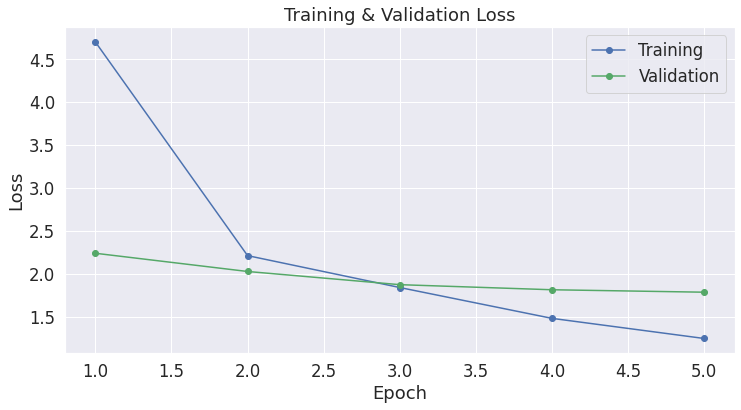

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# cruvas de aprendisaje
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")


plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

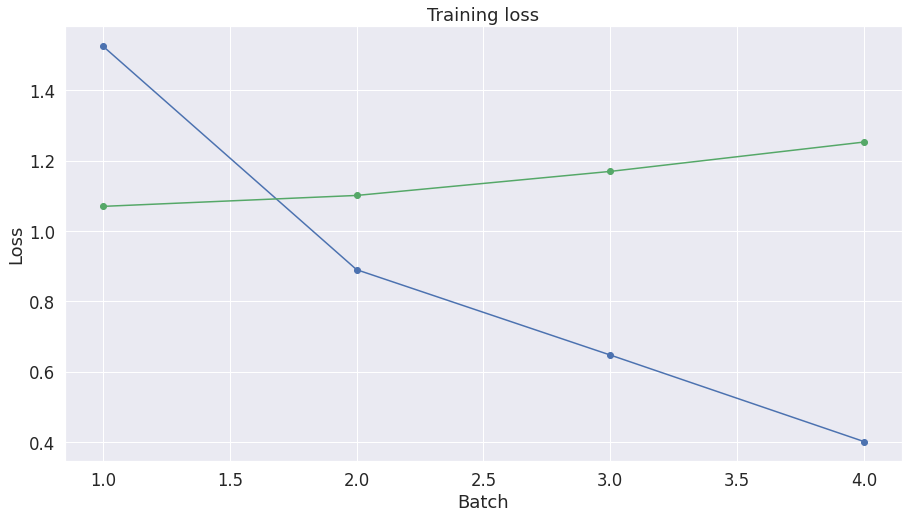

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import numpy as np
import argparse
import cv2
from itertools import compress
output_dir = '/content/drive/My Drive/ModelPoema'

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
torch.save(args, os.path.join(output_dir, 'training_args.bin'))

# Good practice: save your training arguments together with the trained model
torch.save(args, os.path.join(output_dir, 'training_args.bin'))

NameError: ignored

# Generacion poemas


In [ ]:
model.eval()

prompt = "llorar"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

# set return_num_sequences > 1
beam_outputs = model.generate(
    generated, 
    max_length=50, 
    num_beams=5, 
    no_repeat_ngram_size=2, 
    num_return_sequences=5, 
    early_stopping=True
)

# now we have 3 output sequences
print("Output:\n" + 100 * '-')
for i, beam_output in enumerate(beam_outputs):
  print("{}: {}".format(i, tokenizer.decode(beam_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: llorar en el pecho.
la sangre de los toros bravos y ruiseñores.
y la faz de las gitanas bravas y mudas. 
las manchadas pieles de pantera y panal.
1: llorar en el pecho.
la sangre de los toros bravos y ruiseñores.
y la faz de las gitanas bravas y fieros. 
las manchadas pieles de pantera y panal.
2: llorar en el pecho.
la sangre de los toros bravos y ruiseñores.
y la faz de las gitanas bravas y fieros. 
las manchadas pieles de pantera y pantorrilla
3: llorar en el pecho.
la sangre de los toros bravos y ruiseñores.
y la faz de las gitanas bravas y mudas. 
las manchadas pieles de pantera y pantorral
4: llorar en el pecho.
la sangre de los toros bravos y ruiseñores.
y la faz de las gitanas bravas y fieros. 
las manchadas pieles de pantera y pantorral


In [ ]:
import os
file = open("/ruta/filename.txt", "w")
file.write("Primera línea" + os.linesep)
file.write("Segunda línea")
file.close()

In [ ]:

import torch
torch.manual_seed(0)
#prompt = "pajaros"
prompt = "<|startoftext|>"
generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)
# deactivate top_k sampling and sample only from 92% most likely words
sample_output = model.generate(
    generated, 
    do_sample=True, 
    max_length=150, 
    top_p=0.92, 
    top_k=0.8
)

print("****")
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


ValueError: ignored

In [ ]:
import os
file = open("/content/gdrive/MyDrive/ejemplo01.txt.txt", "w")
file.write("Primera línea" + os.linesep)
file.write("Segunda línea")
file.close()

In [ ]:
# -*- coding: utf-8 -*-
"""
spanish_poetry_functions.py
@author: Guillermo Serrano Nájera
"""
import re, string, unicodedata
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

def perform_analysis(poem_path):
    
    poem = []
    with open(poem_path, "r") as f:
        lines = f.readlines()
        poem = [l.strip() for l in lines if l.strip()]
                
    metric_syllables = list()
    phonologic_syllables = list()
    verse_classification = list()
    accents = list()
    synalephas = list()
    synalephas_hyatus = list()
    
        
    #analyse each individual verse
    for verse in poem:
        
        verse = clean_punctuation(verse)
        words_verse = verse.split()
        
        verse_accents = []
        syllable_number = 0
        verse_type = 0
        verse_synalephas = []
        verse_synalephas_hyatus = []
        total_words = len(words_verse)
        
        prev_syllables = []
        prev_tonic = []
        
        word_idx = 0
        
        for word in words_verse:

            current_syllables = syllables(word)
            current_tonic = tonic_syllable(current_syllables)
            length = len(current_syllables)
            syllable_number += length
            accentuated_word = not_clitic_word(word)
            
            if accentuated_word:
                verse_accents.append(syllable_number + current_tonic)
            else:
                current_tonic = 0

            [synalepha, synalepha_hyatus] = detect_synalephas(prev_syllables,\
                current_syllables, prev_tonic, current_tonic)

            if synalepha:
                verse_synalephas.append(syllable_number-length)
            if synalepha_hyatus:                
                verse_synalephas_hyatus.append(syllable_number-length)
            
            prev_syllables = current_syllables
            prev_tonic = current_tonic

            if word_idx == total_words-1: # if it is the last word in the verse
                if current_tonic == -1: # aguda
                    verse_type = 1
                elif current_tonic < -2: # esdrújula o sbreesdrújula
                    verse_type = -1
                else: # llana
                    verse_type = 0
            
            word_idx += 1
                
#        [verse_metric_syllables, verse_accents] = accent_correction_by_synalephas(syllable_number,\
#                verse_accents, verse_synalephas)
        verse_metric_syllables = syllable_number - len(verse_synalephas)    
        verse_metric_syllables += verse_type
            
        metric_syllables.append(verse_metric_syllables)
        phonologic_syllables.append(syllable_number)
        verse_classification.append(verse_type)
        accents.append(verse_accents)
        synalephas.append(verse_synalephas)
        synalephas_hyatus.append(verse_synalephas_hyatus)
        
    return [poem, metric_syllables, phonologic_syllables, verse_classification, accents, synalephas, synalephas_hyatus]
    
def clean_punctuation(text):
    return re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    
def clean_tildes(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def syllables(word):  
    '''
    Returns a list with the syllables of word
    To do it, it finds all possible syllable begginings in spanish
    
    Devuelve una lista con las sílabas de la palabra (variable word)
    Para hacerlo encuentra los comienzos de silaba posibles en castellano
    '''
    creed = re.compile(u'''((b|br|bl|c|ch|cr|cl|d|dr|f|fr|fl|gu|g|
                 gr|gl|gü|h|j|k|kr|kl|l|ll|m|mn|n|ñ|p|ph|
                 pr|pl|ps|qu|q|rr|r|s|t|tr|tl|v|vr|vl|w|x|y|z))?          
                 (ih?u(?![aeoáéíóú])|                               
                  uh?i(?![aeoáéíóú])|                               
                  uy(?![aeiouáéíóú])|                               
                  [iuü]?[aeoáéíóú](h?[iuy](?![aeoiuáéíóú]))?|      
                  [ui]|                                             
                  y(?![aeiouáéíóú]))''', 
                 re.UNICODE | re.IGNORECASE | re.VERBOSE)

    pos = []
    for m in creed.finditer(word):
        pos.append(m.start())
    
    pos.append(len(word))
    
    syllables_word = [word[pos[x]:pos[x+1]] for x in range(len(pos)-1)]
    
    return syllables_word

def tonic_syllable(syllables_word):
    '''
    Takes a list with the syllables of a word, like the ones returned by
    syllables function and returns the postition of the tonic syllables, using:
    aguda = -1; llana = -2; esdrújula = -3; sobresdrújula < -3
    
    Toma una lista de silabas de una sola palabra, como las que devuelve
    la función syllables y retorna la posición de la silaba tónica, siendo:
    aguda = -1; llana = -2; esdrújula = -3; sobresdrújula < -3.
    '''
    accents = re.compile(u'[áéíóú]',re.UNICODE | re.IGNORECASE)
    llana_sin_acento = re.compile('[nsaeiou]',re.UNICODE | re.IGNORECASE)
    
    orthographic_accent = False
    syllables_number = len( syllables_word )
    syllabic_range = list( range( -1, -(syllables_number+1), -1 ) )

    # Test if there is ortographic accents
    # Comprueba la presencia de acentos ortográficos
    for syllable_idx in syllabic_range:

        current_syllable = syllables_word[syllable_idx]

        if accents.search( current_syllable ):
            orthographic_accent = True
            break
    
    # If the word has accent, the that is the tonic syllable
    # Si tiene acento, entonces la silaba tónica es la acentuada    
    if orthographic_accent:
        tonic = syllable_idx
    
    # If it has no accent, only can be llano or aguda
    # Si no tiene acento, entonces es llana o aguda   
    else:
        
        # if it has only one syllable, is aguda
        # Si es monosílaba es aguda
        if syllables_number == 1:
            tonic = -1
        
        else:
            last_syllable = syllables_word[len(syllables_word)-1]
            last_letter = last_syllable[len(last_syllable)-1]
       
            # If the last letter is n/s/vowel and no accents, is llana
            # Si la última letra es n/s/vocal y no tiene acento, será llana
            if llana_sin_acento.search(last_letter):
                tonic = -2
            
            # Otherwise is aguda
            # En los demás casos sera aguda
            else:
                tonic = -1              
        
    return tonic

def not_clitic_word(word):
    '''    
    Esta función toma una palabra y retorna un booleano definiendo si se trata
    de una palabra inacentuada
    '''
    
    word = word.lower()
    palabras_cliticas = [
    'el','los','la','las','me','nos','te','os','lo','le','les','se','mi',
    'mis','tu','tus','su','sus','nuestro','nuestros','nuestra','nuestras','vuestro',
    'vuestra','vuestros','vuestras','que','quien','quienes','cuyo','cuya','cuyos',
    'cuyas','cual','cuales','como','cuando','do','donde','adonde','cuan','tan',
    'cuanto','cuanta','cuantos','cuantas','a','ante','bajo','cabe','con','contra',
    'de','desde','durante','en','entre','hacia','hasta','mediante','para','por',
    'sin','so','sobre','tras','versus','aunque','conque','cuando','luego','mas',
    'mientras','ni','o','u','pero','porque','pues','que','si','sino','y','e',
    'aun','excepto','hasta','incluso','don','doña','fray','frey','san','sor',
    'santo','santa','santos','santas','al'] #¿Al falta?
            
    accentuated_word = True        
    if word in palabras_cliticas:
        accentuated_word = False
        
    return accentuated_word
    
def coditional_clitic_word( word ):
    '''
    en desarrollo
    '''
    cliticas_condicionales = []
            
    warning = False        
    if word in cliticas_condicionales:
        warning = True
        
    return warning

def detect_synalephas(prev_syllables, current_syllables, prev_tonic, current_tonic):
    '''    
    toma una pareja de palabras y devuelve dos booleanos que determina si entre
    ambas palabras se encuentra una sinalfa o una sinalefa-hiato
    '''
    synalepha = False
    synalepha_hyatus = False
    
    #☺ It there is a previous word, look for synalepha
    # Si hay una palabra previa, entonces busca si hay synalepha
    if len(prev_syllables) > 0:
         
         # Determine if previous word finihs in vowel(v) vh
         # Busca si la palabra anterior acaba por vocal(V) o por Vh.
         vowels_final = re.compile('([aeiou]h?$)', re.UNICODE | re.IGNORECASE)
         
         # Determine if the next word starts with h
         # Busca si la palabra siguiente comienza por vocales o por h
         vowels_init = re.compile('h?[aeiou]', re.UNICODE | re.IGNORECASE)
         
         # Determine if the the word starts with "y" not followed by vowels
         # Busca si la palabra comienza por 'y' no seguida por vocales
         y_griega = re.compile( 'y[^aeiou]?$', re.UNICODE | re.IGNORECASE)
         
         last_syllable = prev_syllables[-1]
         first_syllable = current_syllables[0]
         
         # If the previous syllable finish with vowel or y
         # Si la sílaba previa acaba por vocal o por 'y' griega        
         if vowels_final.search( last_syllable ) or y_griega.match( last_syllable ):
             
             # If the next syllable starts with vowel or y
             # Si la sílaba siguiente empieza por vocal o por 'y' griega no seguida de vocal  
             if vowels_init.match( first_syllable ) or y_griega.match( first_syllable ):
                 
                 # There is a synalepha
                 # Hay sinalefa
                 synalepha = True
                 
                 # Identify the presence of hyatus
                 # Identificar la presencia de hiato
                 
                 # if next word finishs any of the syllables is tonic
                 # Si la palabra anterior acaba por sílaba tónica o la siguiente empeiza por tal       
                 if (prev_tonic == -1) or current_tonic == -len(current_syllables):
                     
                     # There is hyatus
                     # Hay hiato
                     synalepha_hyatus = True
                          
    return ( synalepha, synalepha_hyatus )

# deprecated
def accent_correction_by_synalephas( verse_syllables, accents_vector, synalephas_vector ):
    
    # Calculate the number of synalephas
    # Calcula el número de sinalefas
    synalephas_number = len( synalephas_vector )

    # Calculate the number of metric syllables, substracting the synalephas
    # Calcula el número de silabas métricas restando las sinalefas
    metric_syllables = verse_syllables - synalephas_number
    
    # Relocate the accents from the synalepha
    # Reposiciona los acentos a partir de la sinalefa
    if synalephas_number > 0:
        
        # Go to all synalephas in the vector
        # Recorre las sinalefas registradas en el vector
        for synalepha in synalephas_vector:
            
            synalepha = synalepha-1
            
            # Initialize the vector with the accents
            # Inicializamos el vector de acentos            
            acc_idx = 0
            
            # Run through the vector of accents
            # Recorremos el vector de acentos
            for accent in accents_vector:
                
                # If the position of the accent exceeds the synalepha
                # Si la posición del acento supera la sinalefa
                if accent >= synalepha:
                    
                    # substract 1
                    # Le restamos 1 a su posición
                    accents_vector[ acc_idx ] = accent - 1
                
                # Actualize the vector of accents
                # Actualizamos el vector de acentos
                acc_idx += 1
                
    return( metric_syllables, accents_vector )

def syllable_correction(poemAnalysis):
    poem_syllables = []
    poem_accents = []
    for vIdx in range(len(poemAnalysis.poem)):
        verse_sylls = syllables(poemAnalysis.poem[vIdx])
        verse_accts =np.array( poemAnalysis.accents[vIdx])
        
        synalephas = np.unique(poemAnalysis.synalephas[vIdx] + poemAnalysis.synalephas_hyatus[vIdx])
        for syn in synalephas:
            verse_sylls[syn-1] = verse_sylls[syn-1] + verse_sylls[syn]

            # find the index of the elements in the vector of accents, bigger than the synalepha
            indices = [ idx for idx, val in enumerate(verse_accts) if val >= syn ]

            # substract 1 to the positions
            verse_accts[indices] = [val - 1 for val in verse_accts[indices]]

        verse_sylls = [idx for syn, idx in enumerate(verse_sylls) if syn not in synalephas]
       
        poem_syllables.append(verse_sylls)
        poem_accents.append(list(verse_accts))
        
    return poem_syllables, poem_accents
    
def rhyme(word1, word2):
    s1 = syllables(word1)
    s2 = syllables(word2)
    
    t1 = tonic_syllable(s1)
    t2 = tonic_syllable(s2)

    endC1 = sound_correction("".join(s1[t1:]))
    endC2 = sound_correction("".join(s2[t2:]))
    
    endA1 = re.sub(r'[^aeiouáéíóúáü]', '', endC1, flags=re.IGNORECASE)
    endA2 = re.sub(r'[^aeiouáéíóúáü]', '', endC2, flags=re.IGNORECASE)

    strong = (endC1 == endC2)
    soft = (endA1 == endA2)
        
    return strong, soft

def sound_correction(text):
    '''
    R suave y R fuerte?
    '''
    
    text = text.replace("v","b")
    
    text = text.replace("ca","ka")
    text = text.replace("ce","ze")
    text = text.replace("ci","zi")
    text = text.replace("co","ko")
    text = text.replace("cu","ku")
    
    text = text.replace("que","ke")
    text = text.replace("qui","ki")
    
    text = text.replace("ge","je")
    text = text.replace("gi","ji")
    
    text = text.replace("gue","ge")
    text = text.replace("gui","gi")
    
    text = clean_tildes(text)
    
    # clean first letter for consontant rhyme
    if text[0] not in ["a","e","i","o","u"]:
        text = text[1:]
        
    return text

def final_rhyme_analysis(poem):
    final_words = []    
    for verse in poem:
        verse = clean_punctuation(verse)
        words_verse = verse.split()
        final_words.append(words_verse[-1])
        
    keys = string.ascii_lowercase
    rhyme_dict = {}

    for word1 in enumerate(final_words):
        rhyme_found = 0
        for word2 in enumerate(final_words):
            [R,r] = rhyme(word1[1], word2[1])
            
            if word1[1] != word2[1]:
            
                if word1[0] not in sum(rhyme_scheme.values(),[]):
                    
                    if R:
                        rhyme_found = 1
                        if keys[0].upper() not in rhyme_scheme.keys():
                            rhyme_scheme[keys[0].upper()] = [word1[0], word2[0]]
                        else:
                            rhyme_scheme[keys[0].upper()] = rhyme_scheme[keys[0].upper()] + [word1[0]]
                                        
                        
                    elif r:
                        rhyme_found = 1
                        if keys[0] not in rhyme_scheme.keys():
                            rhyme_scheme[keys[0]] = [word1[0], word2[0]]
                        else:
                            rhyme_scheme[keys[0]] = rhyme_scheme[keys[0]] + [word1[0]]
    if rhyme_found:
        keys=keys[1:]  

    return rhyme_scheme

def rhyme_scheme(poem):
    # This function takes the last word of each verse and returns two lists of 
    # the verse which rhyme in consonant and asonant.
    final_words = []    
    for verse in poem:
        verse = clean_punctuation(verse)
        words_verse = verse.split()
        final_words.append(words_verse[-1])
        
    con_list = []
    aso_list = []
    
    # Test verses whith rhymes
    for r in range(len(final_words)):
        con_ind = []
        aso_ind = []
        for c in range(len(final_words)):
            [con, aso] = rhyme(final_words[r],final_words[c])

            if con:
                con_ind.append(c)
            if aso:
                aso_ind.append(c)

        if len(con_ind) > 1:
            con_list.append(sorted(con_ind))
        if len(aso_ind) > 1:
            aso_list.append(sorted(aso_ind))

    con_list = [list(x) for x in set(tuple(x) for x in con_list)]
    aso_list = [list(x) for x in set(tuple(x) for x in aso_list)]

    # Create a dictionary with the rhymes
    rhyme_dict = {}

    keys = string.ascii_uppercase
    for rhymes in range(len(con_list)):
        rhyme_dict[keys[rhymes]] = con_list[rhymes]

    keys = string.ascii_lowercase
    for rhymes in range(len(aso_list)):
        rhyme_dict[keys[rhymes]] = aso_list[rhymes]
        
    
    return con_list, aso_list, rhyme_dict
    
def compass_analysis(poemAnalysis):
    
    compass = []
    mean_compass = []
    for verse in range(len(poemAnalysis.accents)):
        accs = [0]+poemAnalysis.accents[verse]
        compass.append([y - x for x,y in zip(accs,accs[1:])])
        mean_compass.append(np.mean(compass[verse]))
    
    return compass, mean_compass
    
def plotPoemAnalysis(poemAnalysis):
    shape = [len(poemAnalysis.poem), max([len(sylls) for sylls in poemAnalysis.correct_syllables])]
    grid = np.zeros(shape, dtype=int, order='C')
    
    # fill the grid
    for vIdx in range(shape[0]):
        grid[vIdx, 0:len(poemAnalysis.correct_syllables[vIdx])] = -1 # -1 for another color
        
        if poemAnalysis.verse_classification[vIdx]==1:
            grid[vIdx, len(poemAnalysis.correct_syllables[vIdx])] = 2 # add 2 if a syllable added if the verse is oxítino
        
        elif poemAnalysis.verse_classification[vIdx]==-1:
            grid[vIdx, len(poemAnalysis.correct_syllables[vIdx])-1] = -2 # add -1 if the verse is paroxítono
            
        for aIdx in poemAnalysis.correct_accents[vIdx]:
            grid[vIdx, aIdx] = 1
    


    data_table = np.zeros([shape[0], 5], dtype = int, order='C')
    
    c = 2
    for k in sorted(poemAnalysis.rhyme_dict.keys()):
        
        if k.isupper():
            for vIdx in poemAnalysis.rhyme_dict[k]:
                data_table[vIdx, :] = data_table[vIdx, :]+c
            
        else:
            for vIdx in poemAnalysis.rhyme_dict[k]:
                if data_table[vIdx, 0] == 0:
                    data_table[vIdx, :] = data_table[vIdx, :]+1
                else:
                    data_table[vIdx, :] = -data_table[vIdx, :]
        
        c += 1
    
    fig = plt.figure(facecolor="lightgrey")
    ax1 = fig.add_subplot(1,1,1)
    
    fig2 = plt.figure(facecolor="lightgrey")
    ax2 = fig2.add_subplot(1,1,1)
    
    cmapPoem = LinearSegmentedColormap.from_list('mycmap', ['lightcyan', 'paleturquoise', 'lightgrey', 'sandybrown', 'peachpuff'])
    ax1.pcolor(grid[::-1,:], cmap=cmapPoem, vmin=-2, vmax=2, edgecolors='k', linewidths=1)
    ax1.axis('off')
    
    ax2.pcolor(data_table[::-1,:], cmap="Set2", vmin=np.min(data_table), vmax=c, edgecolors='k', linewidths=1)
    ax2.axis('off')
    
    for vIdx in reversed(range(grid.shape[0])):
        for sIdx in range(grid.shape[1]):
            if sIdx < len(poemAnalysis.correct_syllables[shape[0]-1-vIdx]):
                ax1.text(sIdx + 0.5, vIdx + 0.5, poemAnalysis.correct_syllables[shape[0]-1-vIdx][sIdx],
                         horizontalalignment='center',
                         verticalalignment='center',
#                         fontweight='bold'
                         )
                ax2.text(2.5, shape[0]-1-vIdx + 0.5, poemAnalysis.verse_classification[shape[0]-1-vIdx],
                         horizontalalignment='center',
                         verticalalignment='center',
#                         fontweight='bold'
                         )
                ax2.text(3.5, shape[0]-1-vIdx + 0.5, poemAnalysis.metric_syllables[shape[0]-1-vIdx],
                         horizontalalignment='center',
                         verticalalignment='center',
#                         fontweight='bold'
                         )
                ax2.text(4.5, shape[0]-1-vIdx + 0.5, poemAnalysis.phonologic_syllables[shape[0]-1-vIdx],
                         horizontalalignment='center',
                         verticalalignment='center',
#                         fontweight='bold'
                         )
    
    for k in poemAnalysis.rhyme_dict.keys():
        if k.isupper():
            for vIdx in poemAnalysis.rhyme_dict[k]:
                ax2.text(0.5, shape[0]-1-vIdx + 0.5, k,
                             horizontalalignment='center',
                             verticalalignment='center',
    #                         fontweight='bold'
                             )
                data_table[vIdx] = 1
        else:
            for vIdx in poemAnalysis.rhyme_dict[k]:
                ax2.text(1.5, shape[0]-1-vIdx + 0.5, k,
                             horizontalalignment='center',
                             verticalalignment='center',
    #                         fontweight='bold'
                             )
                data_table[vIdx] = 1

    fig.show()

def plot_compass(poemAnalysis):
    boxprops = dict(linestyle='-', linewidth=3, color='darkgray')
    medianprops = dict(linestyle='-', linewidth=2.5, color='gold')
    meanlineprops = dict(linestyle='--', linewidth=2.5, color='violet')
    whiskersprops = dict(linestyle='-', linewidth=2.5, color='darkgray')
    capprops = dict(linestyle='-', linewidth=2.5, color='darkgray')
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.margins(y=0.05)
    ax.boxplot(poemAnalysis.mean_compass, whis='range', meanline=True, showmeans=True, \
               boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskersprops,\
               capprops=capprops, meanprops=meanlineprops)
    ax.set_title('mean compass variation per verse', fontsize=20)

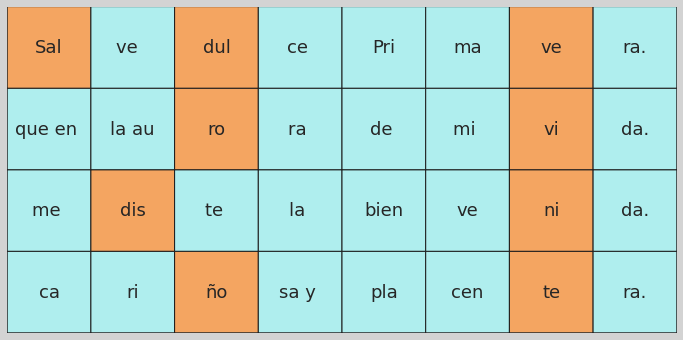

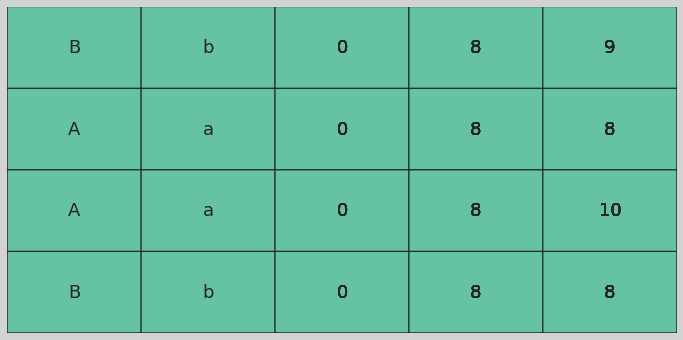

In [ ]:
# -*- coding: utf-8 -*-
"""
pyesia
A toolbox for spanish poetry analysis
@author: Guillermo Serrano Nájera
"""


class poemAnalysis:
    
    def __init__(self, poem_path):
        self.poem_path = poem_path
        
        [self.poem, self.metric_syllables, self.phonologic_syllables, self.verse_classification,\
             self.accents, self.synalephas, self.synalephas_hyatus]=perform_analysis(poem_path)
        
        self.con_rhymes, self.aso_rhymes, self.rhyme_dict = rhyme_scheme(self.poem)
        self.correct_syllables, self.correct_accents = syllable_correction(self)
        
        self.compass, self.mean_compass = compass_analysis(self)
    
    def plot_analyisis(self):
        plotPoemAnalysis(self)
       # plot_compass(self)
        
        
#p = poemAnalysis("Sombras_De_Los_Dias_De_Venir.txt")
#p = poemAnalysis("XXIX_Antonio_Machado.txt")
#p = poemAnalysis("Tus_Ojos_Octavio_Paz.txt")
p = poemAnalysis("/content/gdrive/MyDrive/haiku_borges.txt")
p.plot_analyisis()


#Detectar rimas
#Localizar sílabas tónicas
#Localizar sinalefas y sinalefas-hiato
#Contar de sílabas

In [ ]:
p = poemAnalysis("/content/gdrive/MyDrive/ejemplo01.txt")
p.plot_analyisis()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Guardar El modelo

In [ ]:
import os

output_dir = '/content/drive/My Drive/PoemsGpt2'

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
torch.save(args, os.path.join(output_dir, 'training_args.bin'))
torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Cargar El modelo

In [ ]:
model = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
model.to(device)